In [268]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay, auc, roc_curve, accuracy_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

pd.set_option("display.max_columns", None)
pd.options.display.max_rows = 4000


In [149]:
import pymc3 as pm
from pymc3 import glm
import bambi

In [ ]:
def plot_traces(traces, model, retain=0):
    """
    Convenience function:
    Plot traces with overlaid means and values
    """
    summary = az.summary(traces, stat_funcs={"mean": np.mean}, extend=False)
    ax = az.plot_trace(
        traces,
        lines=tuple([(k, {}, v["mean"]) for k, v in summary.iterrows()]),
    )

    for i, mn in enumerate(summary["mean"].values):
        ax[i, 0].annotate(
            f"{mn:.2f}",
            xy=(mn, 0),
            xycoords="data",
            xytext=(5, 10),
            textcoords="offset points",
            rotation=90,
            va="bottom",
            fontsize="large",
            color="C0",
        )

In [285]:
# Data Source: https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers
# *NOTE: To fetch data, please run ~/get_data.sh script
df = pd.read_csv("data/BankChurners.csv")

# Data

## Data Exploration

In [286]:
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [287]:
# Drop variables that are not required
df.drop(
    [
        "CLIENTNUM",
        "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1",
        "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2",
    ],
    axis=1,
    inplace=True,
)


In [288]:
# Non-null data, balanced data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

In [289]:
df.describe(include="all")

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,10127,10127.000000,10127,10127.000000,10127,10127,10127,10127,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
unique,2,NaN,2,NaN,7,4,6,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Existing Customer,NaN,F,NaN,Graduate,Married,Less than $40K,Blue,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,8500,NaN,5358,NaN,3128,4687,3561,9436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,46.325960,NaN,2.346203,NaN,NaN,NaN,NaN,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,NaN,8.016814,NaN,1.298908,NaN,NaN,NaN,NaN,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,NaN,26.000000,NaN,0.000000,NaN,NaN,NaN,NaN,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,NaN,41.000000,NaN,1.000000,NaN,NaN,NaN,NaN,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,NaN,46.000000,NaN,2.000000,NaN,NaN,NaN,NaN,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,NaN,52.000000,NaN,3.000000,NaN,NaN,NaN,NaN,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000


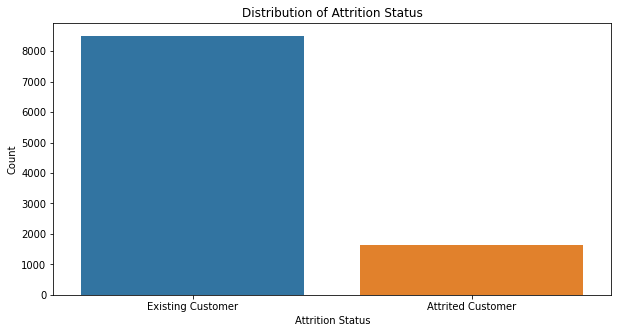

In [290]:
# Target Variable
m = df["Attrition_Flag"].value_counts()
m = m.to_frame()
m.reset_index(inplace=True)
m.columns = ["Attrition Status", "Count"]
plt.subplots(figsize=(10, 5))
sns.barplot(y="Count", x="Attrition Status", data=m)
plt.xlabel("Attrition Status")
plt.ylabel("Count")
plt.title("Distribution of Attrition Status")
plt.show()


## Data Pre-processing

### Convert target variable to binary variable

In [291]:
# Convert Categorical Variables to Numerical (1 == Bad credit)
def attrition_status(status):
    if status == "Existing Customer":
        return 0
    else:
        return 1
df["Attrition_Flag"] = df["Attrition_Flag"].apply(attrition_status)
df["Attrition_Flag"].value_counts()

0    8500
1    1627
Name: Attrition_Flag, dtype: int64

### Dummification of categorical variables (OneHotEncoding)

As there are categorical values within the dataset, encoding of categorical variables is required. For non-hierarchial variables, dummification is required (e.g, Marital status, Gender and Card category), whereas Label encoding is recommended for variables with rank ordering relationship (e.g., Income level and Education level)

In [292]:
cat_features = [
    col for col in df.columns
    if (df[col].dtype == "object") & (col != "Attrition_Flag")
]
num_features = [
    col for col in df.columns
    if (df[col].dtype != "object") & (col != "Attrition_Flag")
]

In [293]:
df["Education_Level"].value_counts()

Graduate         3128
High School      2013
Unknown          1519
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: Education_Level, dtype: int64

In [294]:
le_features = ["Income_Category", "Education_Level"]
oe_features = [i for i in cat_features if i not in le_features]

In [295]:
def education_encoder(status):
    if status == "Unknown":
        return 0
    elif status == "Uneducated":
        return 1
    elif status == "High School":
        return 2
    elif status == "College":
        return 3
    elif status == "Graduate":
        return 4
    elif status == "Post-Graduate":
        return 5
    elif status == "Doctorate":
        return 6


def income_category(status):
    if status == "Unknown":
        return 0
    elif status == "Less than $40K":
        return 1
    elif status == "$40K - $60K":
        return 2
    elif status == "$60K - $80K":
        return 3
    elif status == "$80K - $120K":
        return 4
    elif status == "$120K +":
        return 5


In [299]:
df_y = df["Attrition_Flag"]
df_x = df.loc[:, num_features].astype("float32")

le_count = 0
onehot_encoders = {}
for col in oe_features:
    oe = OneHotEncoder(handle_unknown='ignore', drop="first")
    onehot_encoders[col] = oe
    df_onehot = pd.DataFrame(oe.fit_transform(df[[col]]).toarray())
    df_onehot.columns = oe.get_feature_names_out()
    le_count += 1
    df_x = pd.concat([df_x, df_onehot], axis=1)
print("%d columns were onehot encoded." % le_count)

df_x["Income_Category"] = df["Income_Category"].apply(income_category)
df_x["Education_Level"] = df["Education_Level"].apply(education_encoder)

3 columns were onehot encoded.


### Data Standardisation

In [300]:
# scaler = RobustScaler()
# df_x[num_features] = scaler.fit_transform(df_x[num_features])
scaler = StandardScaler()
df_x[num_features] = scaler.fit_transform(df_x[num_features])

In [301]:
df_x.head()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_M,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver,Income_Category,Education_Level
0,-0.165406,0.503368,0.384621,0.763943,-1.327136,0.492404,0.446622,-0.473422,0.488971,2.623495,-0.959707,-0.973895,3.834002,-0.775882,1.0,1.0,0.0,0.0,0.0,0.0,0.0,3,2
1,0.333570,2.043199,1.010715,1.407306,-1.327136,-0.411616,-0.041367,-0.366667,-0.008486,3.563293,-0.916433,-1.357340,12.608573,-0.616276,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,4
2,0.583058,0.503368,0.008965,0.120579,-1.327136,-2.219656,-0.573698,-1.426858,-0.445658,8.367214,-0.740982,-1.911206,6.807864,-0.997155,1.0,1.0,0.0,0.0,0.0,0.0,0.0,4,4
3,-0.789126,1.273283,-0.241473,-0.522785,1.641478,-1.315636,-0.585251,1.661686,-0.734100,2.942843,-0.951758,-1.911206,6.807864,1.759686,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,2
4,-0.789126,0.503368,-1.869317,0.763943,-1.327136,-2.219656,-0.430877,-1.426858,-0.302868,6.455682,-1.056263,-1.570366,7.509326,-0.997155,1.0,1.0,0.0,0.0,0.0,0.0,0.0,3,1


In [302]:
df_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_Age              10127 non-null  float32
 1   Dependent_count           10127 non-null  float32
 2   Months_on_book            10127 non-null  float32
 3   Total_Relationship_Count  10127 non-null  float32
 4   Months_Inactive_12_mon    10127 non-null  float32
 5   Contacts_Count_12_mon     10127 non-null  float32
 6   Credit_Limit              10127 non-null  float32
 7   Total_Revolving_Bal       10127 non-null  float32
 8   Avg_Open_To_Buy           10127 non-null  float32
 9   Total_Amt_Chng_Q4_Q1      10127 non-null  float32
 10  Total_Trans_Amt           10127 non-null  float32
 11  Total_Trans_Ct            10127 non-null  float32
 12  Total_Ct_Chng_Q4_Q1       10127 non-null  float32
 13  Avg_Utilization_Ratio     10127 non-null  float32
 14  Gender

In [303]:
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=9509)

In [304]:
train_data = pd.concat([x_train, y_train], axis=1)

### Logistic Regression with non-informative priors (Normal Distribution)

In [305]:
formula = f"Attrition_Flag ~ " + " + ".join(x_train.columns)

In [310]:
priors = {
    "Intercept": bambi.Prior("Normal", mu=0, sigma=100),
    "Regressor": bambi.Prior("Normal", mu=0, sigma=100),
}
model = bambi.Model(
    formula,
    train_data,
    priors=priors,
    family="bernoulli",
)
trace = model.fit()

Modeling the probability that Attrition_Flag==1
Traceback (most recent call last):
  File "/Users/joonkang/.pyenv/versions/3.9.11/lib/python3.9/multiprocessing/forkserver.py", line 274, in main
    code = _serve_one(child_r, fds,
  File "/Users/joonkang/.pyenv/versions/3.9.11/lib/python3.9/multiprocessing/forkserver.py", line 313, in _serve_one
    code = spawn._main(child_r, parent_sentinel)
  File "/Users/joonkang/.pyenv/versions/3.9.11/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
_pickle.UnpicklingError: pickle data was truncated
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Education_Level, Income_Category, Card_Category_Silver, Card_Category_Platinum, Card_Category_Gold, Marital_Status_Unknown, Marital_Status_Single, Marital_Status_Married, Gender_M, Avg_Utilization_Ratio, Total_Ct_Chng_Q4_Q1, Total_Trans_Ct, Total_Trans_Amt, Total_Amt_Chng_Q

ValueError: Not enough samples to build a trace.

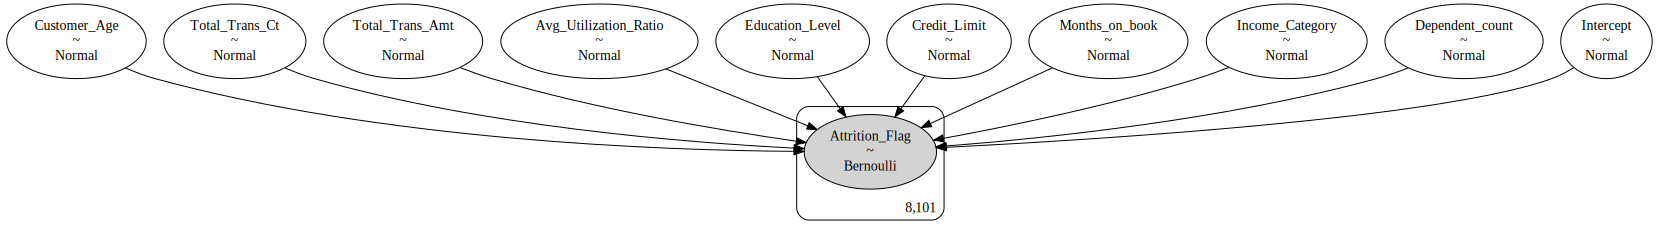

In [308]:
model.graph()

In [309]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-2.160,0.092,-2.339,-1.996,0.001,0.001,4553.0,2941.0,1.00
Customer_Age,-0.027,0.057,-0.136,0.074,0.001,0.001,3184.0,2962.0,1.00
Dependent_count,0.165,0.037,0.097,0.236,0.000,0.000,5802.0,2595.0,1.01
Months_on_book,0.024,0.057,-0.089,0.125,0.001,0.001,3238.0,3116.0,1.00
Credit_Limit,-0.322,0.045,-0.406,-0.241,0.001,0.000,4088.0,2975.0,1.00
Total_Trans_Amt,1.453,0.071,1.326,1.592,0.001,0.001,2684.0,2950.0,1.00
Total_Trans_Ct,-2.429,0.079,-2.579,-2.286,0.002,0.001,2362.0,2727.0,1.00
Avg_Utilization_Ratio,-0.815,0.047,-0.902,-0.726,0.001,0.001,4379.0,3256.0,1.00
Education_Level,0.017,0.021,-0.021,0.057,0.000,0.000,5737.0,2904.0,1.00
Income_Category,-0.159,0.028,-0.215,-0.110,0.000,0.000,3841.0,2877.0,1.00


/Users/joonkang/.pyenv/versions/3.9.11/envs/st451_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


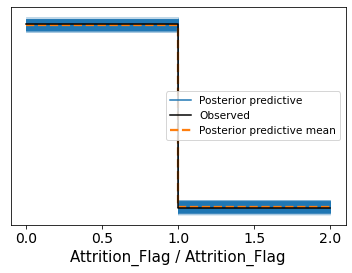

In [263]:
posterior_predictive_ = model.predict(trace, kind="pps", data=x_test)
az.plot_ppc(trace);

In [269]:
# Compute the point prediction by taking the mean
# and defining the category via a threshold.
y_pred = (
    trace["posterior_predictive"]["Attrition_Flag"].values.mean(axis=0).mean(axis=0)
)
y_test_pred = (y_pred >= 0.5).astype("int")

print(f"accuracy = {accuracy_score(y_true=y_test, y_pred=y_test_pred): 0.3f}")

accuracy =  0.861


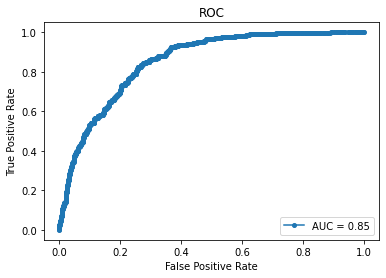

In [265]:
fpr, tpr, thresholds = roc_curve(
    y_true=y_test, y_score=y_pred, pos_label=1, drop_intermediate=False
)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots()
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_display = roc_display.plot(ax=ax, marker="o", markersize=4)
ax.set(title="ROC");

In [192]:
SEED = 42
np.random.seed(SEED)
with pm.Model() as model:
    # Set data container.
    data = pm.Data(
        "data",
        x_train[
            [
                "Customer_Age",
                "Dependent_count",
                "Months_on_book",
                "Credit_Limit",
                # "Total_Trans_Amt",
                # "Total_Trans_Ct",
                # "Avg_Utilization_Ratio",
                # "Education_Level",
                # "Income_Category",
            ]
        ],
    )
    # Define GLM family.
    family = pm.glm.families.Binomial()
    # Set priors.
    priors = {
        "Intercept": pm.Normal.dist(mu=0, sd=10),
        "Customer_Age": pm.Normal.dist(mu=0, sd=10),
        "Dependent_count": pm.Normal.dist(mu=0, sd=10),
        "Months_on_book": pm.Normal.dist(mu=0, sd=10),
        "Credit_Limit": pm.Normal.dist(mu=0, sd=10),
        # "Total_Trans_Amt": pm.Normal.dist(mu=0, sd=10),
        # "Total_Trans_Ct": pm.Normal.dist(mu=0, sd=10),
        # "Avg_Utilization_Ratio": pm.Normal.dist(mu=0, sd=10),
        # "Education_Level": pm.Normal.dist(mu=0, sd=10),
        # "Income_Category": pm.Normal.dist(mu=0, sd=10),
    }
    # Specify model.
    glm.GLM(
        y=y_train,
        x=data,
        family=family,
        intercept=True,
        labels=["Customer_Age", "Dependent_count", "Months_on_book", "Credit_Limit"],
        priors=priors,
    )
    # Configure sampler.
    # trace = pm.sample(5000, chains=5, tune=1000, target_accept=0.87, random_seed=SEED)
    trace = pm.sample(5000, tune=1000, chains=4, random_seed=SEED)


/Users/joonkang/.pyenv/versions/3.9.11/envs/st451_env/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Credit_Limit, Months_on_book, Dependent_count, Customer_Age, Intercept]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 57 seconds.


In [194]:
az.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/joonkang/.pyenv/versions/3.9.11/envs/st451_env/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-1.644,0.030,-1.699,-1.585,0.0,0.0,21055.0,14612.0,1.0
Customer_Age,0.072,0.049,-0.022,0.164,0.0,0.0,17700.0,13700.0,1.0
Dependent_count,0.061,0.031,0.002,0.117,0.0,0.0,21005.0,14157.0,1.0
Months_on_book,0.007,0.049,-0.089,0.096,0.0,0.0,18193.0,13936.0,1.0
Credit_Limit,-0.042,0.031,-0.098,0.017,0.0,0.0,21255.0,14490.0,1.0


Got error No model on context stack. trying to find log_likelihood in translation.
/Users/joonkang/.pyenv/versions/3.9.11/envs/st451_env/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


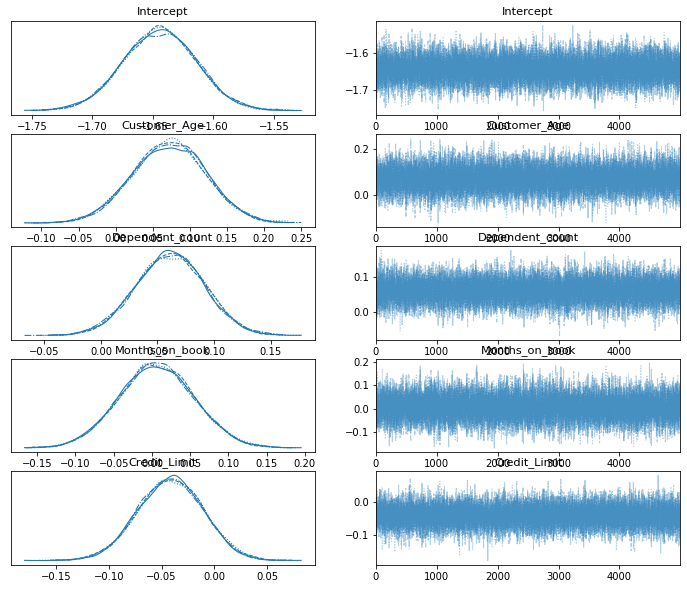

In [179]:
az.plot_trace(data=trace);

In [196]:
# Update data reference.
pm.set_data(
    {
        "data": x_test[
            [
                "Customer_Age",
                "Dependent_count",
                "Months_on_book",
                "Credit_Limit",
                # "Total_Trans_Amt",
                # "Total_Trans_Ct",
                # "Avg_Utilization_Ratio",
                # "Education_Level",
                # "Income_Category",
            ]
        ]
    },
    model=model,
)
# Generate posterior samples.
ppc_test = pm.sample_posterior_predictive(trace, model=model, samples=1000)


/Users/joonkang/.pyenv/versions/3.9.11/envs/st451_env/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [201]:
# Compute the point prediction by taking the mean
# and defining the category via a threshold.
p_test_pred = ppc_test["y"].mean(axis=0)
y_test_pred = (p_test_pred >= 0.5).astype("int")

In [202]:
from sklearn.metrics import accuracy_score

print(f"accuracy = {accuracy_score(y_true=y_test, y_pred=y_test_pred): 0.3f}")

accuracy =  0.847


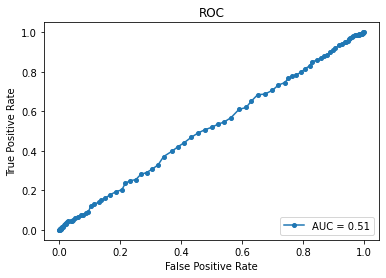

In [203]:
from sklearn.metrics import RocCurveDisplay, auc, roc_curve

fpr, tpr, thresholds = roc_curve(
    y_true=y_test, y_score=p_test_pred, pos_label=1, drop_intermediate=False
)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots()
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_display = roc_display.plot(ax=ax, marker="o", markersize=4)
ax.set(title="ROC");

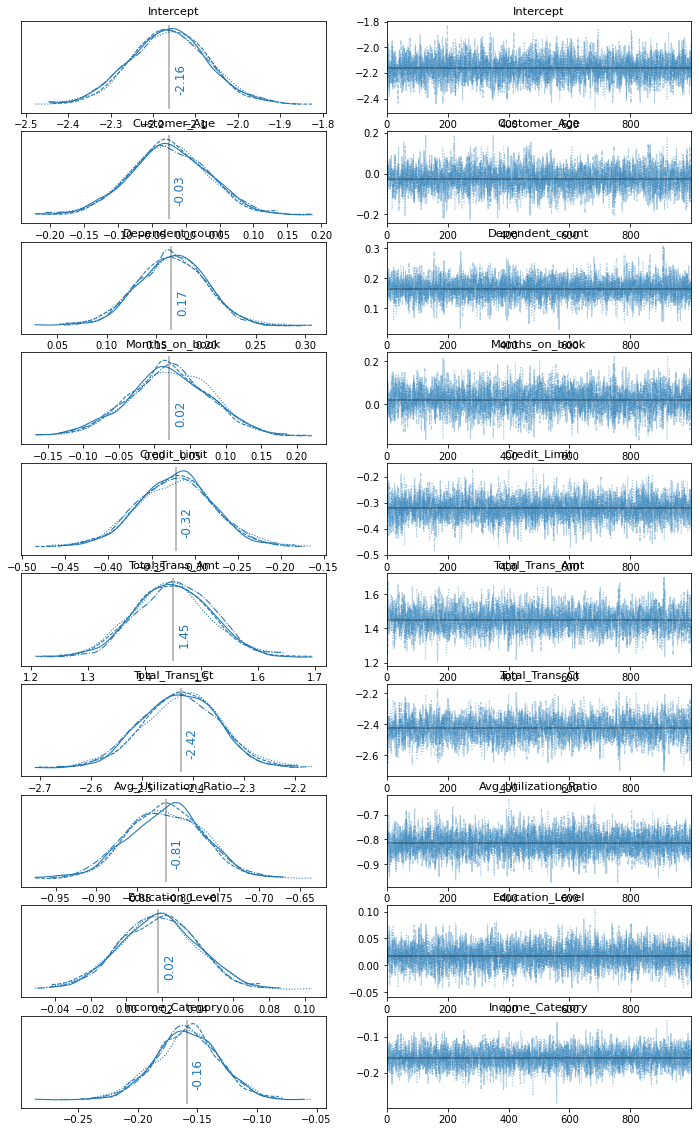

In [130]:
plot_traces(trace, model);

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Customer_Age'}>,
        <AxesSubplot:title={'center':'Dependent_count'}>],
       [<AxesSubplot:title={'center':'Months_on_book'}>,
        <AxesSubplot:title={'center':'Credit_Limit'}>,
        <AxesSubplot:title={'center':'Total_Trans_Amt'}>],
       [<AxesSubplot:title={'center':'Total_Trans_Ct'}>,
        <AxesSubplot:title={'center':'Avg_Utilization_Ratio'}>,
        <AxesSubplot:title={'center':'Education_Level'}>],
       [<AxesSubplot:title={'center':'Income_Category'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

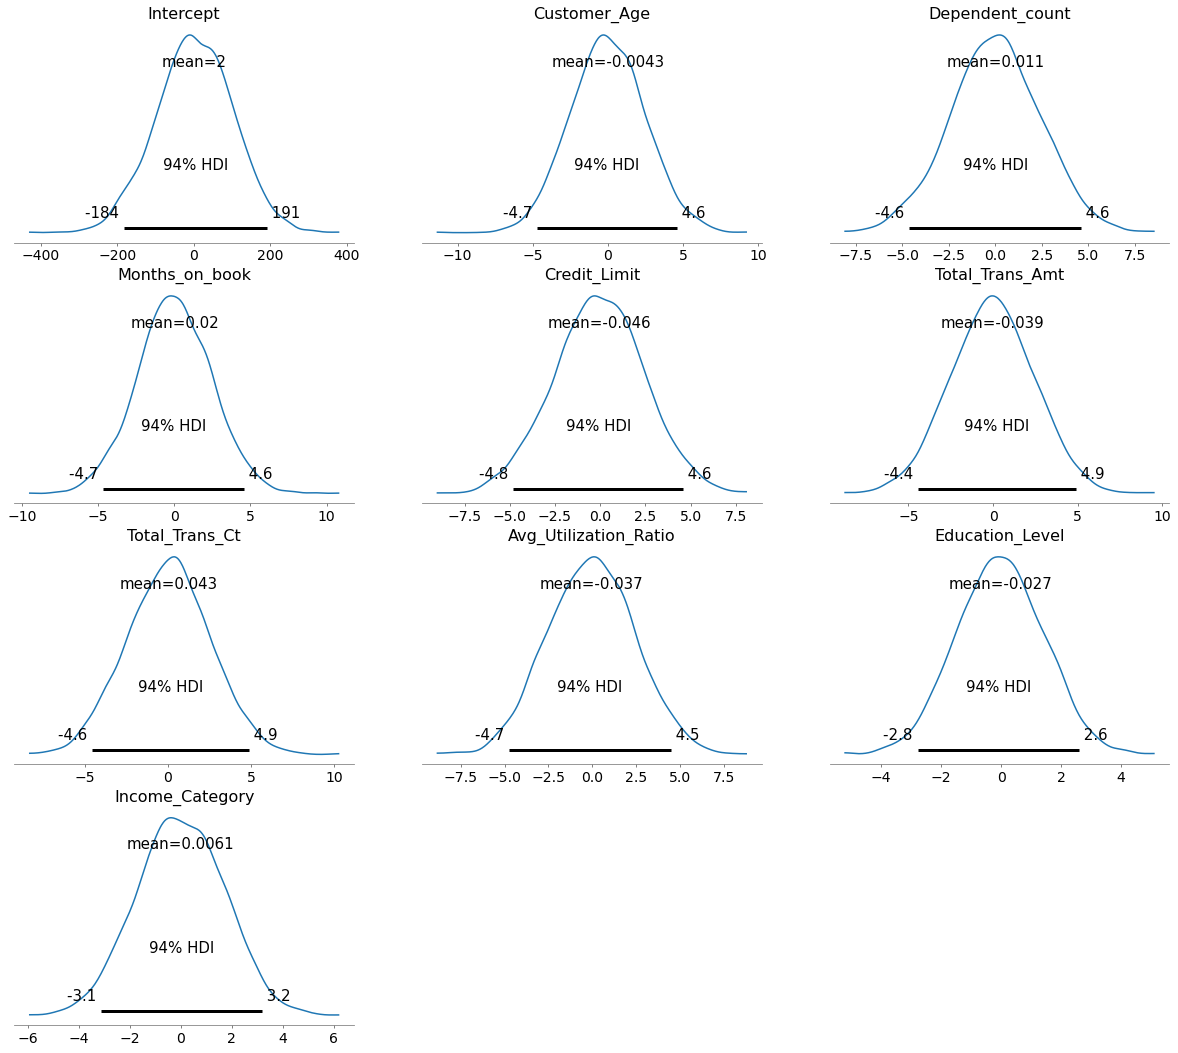

In [131]:
model.plot_priors()

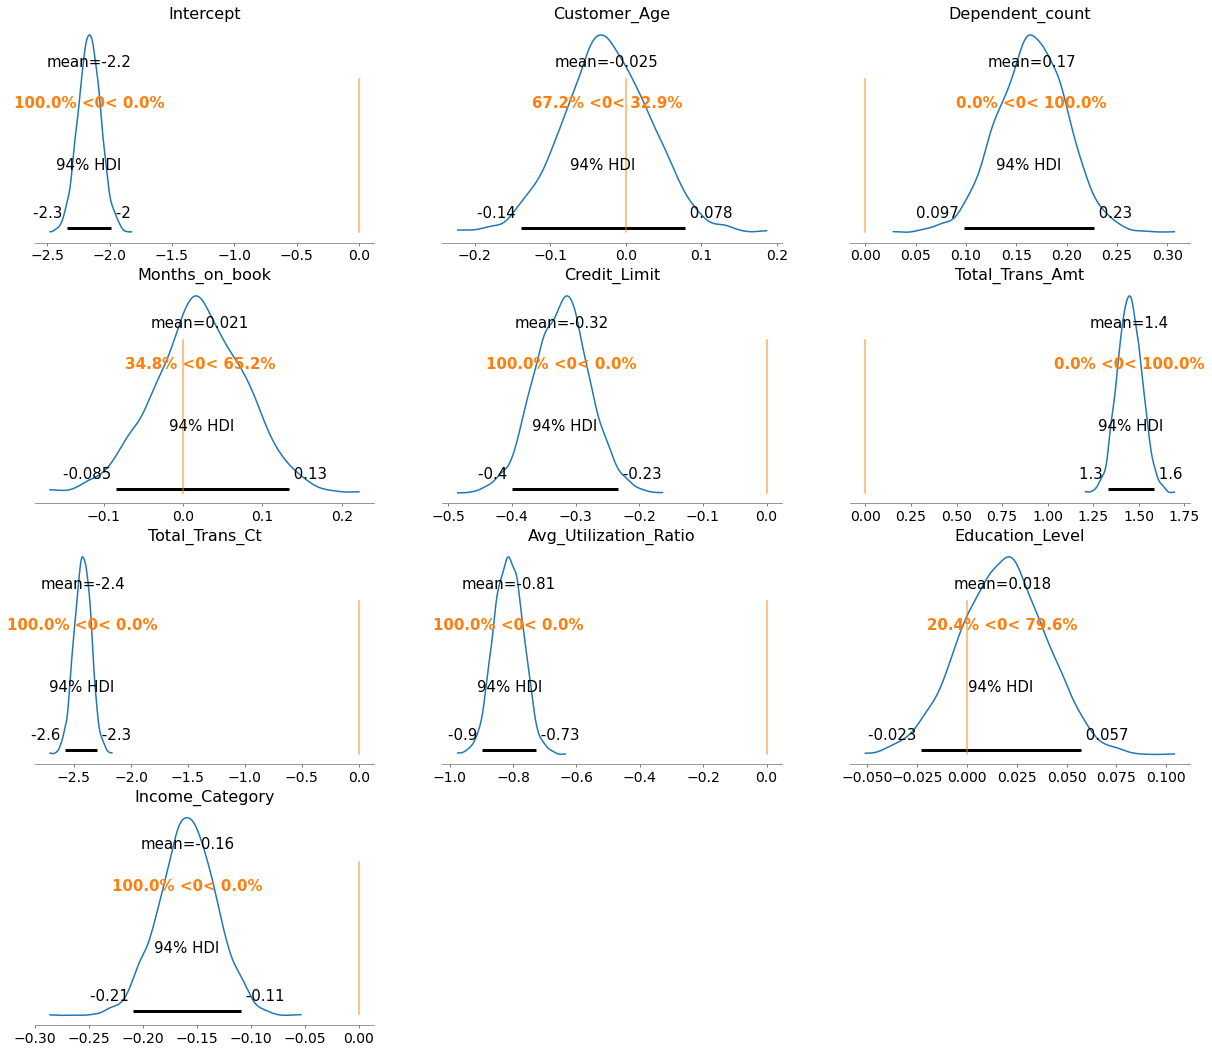

In [132]:
az.plot_posterior(trace, ref_val=0);

In [133]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-2.162,0.091,-2.341,-1.992,0.001,0.001,3947.0,2964.0,1.0
Customer_Age,-0.025,0.058,-0.139,0.078,0.001,0.001,3087.0,3013.0,1.0
Dependent_count,0.165,0.035,0.097,0.227,0.000,0.000,5278.0,2775.0,1.0
Months_on_book,0.021,0.058,-0.085,0.133,0.001,0.001,2898.0,2755.0,1.0
Credit_Limit,-0.322,0.044,-0.400,-0.234,0.001,0.000,4171.0,3050.0,1.0
Total_Trans_Amt,1.449,0.068,1.329,1.582,0.001,0.001,2696.0,3033.0,1.0
Total_Trans_Ct,-2.425,0.075,-2.579,-2.295,0.002,0.001,2294.0,2583.0,1.0
Avg_Utilization_Ratio,-0.815,0.046,-0.897,-0.728,0.001,0.000,4378.0,3061.0,1.0
Education_Level,0.018,0.021,-0.023,0.057,0.000,0.000,4707.0,2559.0,1.0
Income_Category,-0.159,0.027,-0.209,-0.109,0.000,0.000,4380.0,2924.0,1.0


In [138]:
model.predict(trace, data=x_test)

In [140]:
# Select posterior values for the mean probability of voting for Clinton
# Note we stack chains and draws, then vote_posterior has a shape of (n_chains * n_draws, n_obs)
posterior = trace.posterior["Attrition_Flag_mean"].stack(samples=("chain", "draw")).values

# Select 25% of the values in the posterior, making sure we take values from both chains.
posterior = posterior[:, ::4]

In [ ]:
p_test_pred = ppc_test["y"].mean(axis=0)
y_test_pred = (p_test_pred >= 0.5).astype("int")

In [ ]:

# Compute the point prediction by taking the mean
# and defining the category via a threshold.
p_test_pred = ppc_test["y"].mean(axis=0)
y_test_pred = (p_test_pred >= 0.5).astype("int")

In [ ]:
from sklearn.metrics import accuracy_score

print(f"accuracy = {accuracy_score(y_true=y_test, y_pred=y_test_pred): 0.3f}")

In [266]:
from sklearn.linear_model import LogisticRegression

x = x_train[
    [
        "Customer_Age",
        "Dependent_count",
        "Months_on_book",
        "Credit_Limit",
        "Total_Trans_Amt",
        "Total_Trans_Ct",
        "Avg_Utilization_Ratio",
        "Education_Level",
        "Income_Category",
    ]
]
logit = LogisticRegression(fit_intercept=True, max_iter=5000)
# logit = LogisticRegression(fit_intercept=True, penalty="l1", solver="liblinear", max_iter=5000)
logit_model = logit.fit(x, y_train)
pd.DataFrame(logit_model.coef_, columns=x.columns)
y_pred = logit_model.predict_proba(
    x_test[
        [
            "Customer_Age",
            "Dependent_count",
            "Months_on_book",
            "Credit_Limit",
            "Total_Trans_Amt",
            "Total_Trans_Ct",
            "Avg_Utilization_Ratio",
            "Education_Level",
            "Income_Category",
        ]
    ]
)
y_pred = y_pred[:, 1]


[Text(0.5, 1.0, 'ROC')]

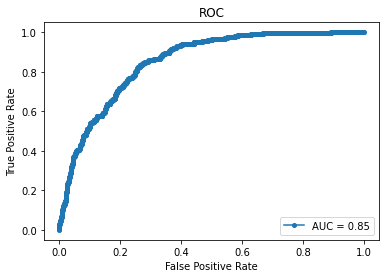

In [267]:

fpr, tpr, thresholds = roc_curve(
    y_true=y_test, y_score=y_pred, pos_label=1, drop_intermediate=False
)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots()
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_display = roc_display.plot(ax=ax, marker="o", markersize=4)
ax.set(title="ROC")


In [127]:
priors = {
    "Intercept": bambi.Prior("Normal", mu=0, sigma=50),
    "Regressor": bambi.Prior("Laplace", mu=0, b=0.05),
}
model = bambi.Model(
    "Attrition_Flag ~ Customer_Age + Dependent_count + Months_on_book + Credit_Limit + Total_Trans_Amt + Total_Trans_Ct + Avg_Utilization_Ratio + Education_Level + Income_Category",
    train,
    priors=priors,
    family="bernoulli",
)
trace = model.fit()


Modeling the probability that Attrition_Flag==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Income_Category, Education_Level, Avg_Utilization_Ratio, Total_Trans_Ct, Total_Trans_Amt, Credit_Limit, Months_on_book, Dependent_count, Customer_Age, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.


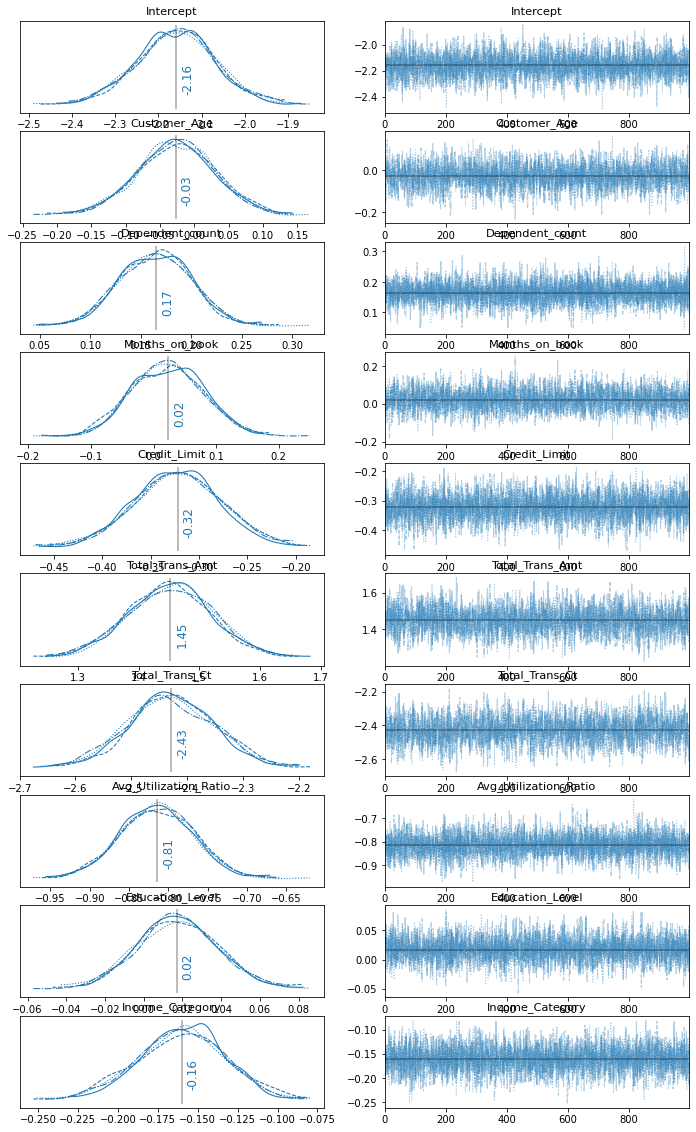

In [120]:
plot_traces(trace, model);

In [122]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-2.159,0.090,-2.332,-1.988,0.001,0.001,4127.0,2917.0,1.00
Customer_Age,-0.027,0.056,-0.134,0.079,0.001,0.001,2992.0,3063.0,1.00
Dependent_count,0.165,0.035,0.103,0.233,0.000,0.000,5697.0,3076.0,1.00
Months_on_book,0.023,0.057,-0.082,0.126,0.001,0.001,3162.0,3154.0,1.00
Credit_Limit,-0.322,0.044,-0.404,-0.236,0.001,0.000,4112.0,3448.0,1.00
Total_Trans_Amt,1.452,0.069,1.318,1.577,0.001,0.001,2382.0,2791.0,1.00
Total_Trans_Ct,-2.428,0.076,-2.571,-2.284,0.002,0.001,2137.0,2629.0,1.00
Avg_Utilization_Ratio,-0.814,0.047,-0.902,-0.728,0.001,0.001,4148.0,2994.0,1.00
Education_Level,0.017,0.021,-0.021,0.056,0.000,0.000,4801.0,2775.0,1.00
Income_Category,-0.160,0.027,-0.213,-0.112,0.000,0.000,3720.0,2920.0,1.01
